# With SAHI

In [56]:
# !pip install -U ultralytics sahi

In [57]:
model_path = "../weights/best_yolo_10_70epochs.pt"

In [58]:
from sahi import AutoDetectionModel
import time

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.5,
    device="cuda",  # or 'cuda:0'
)


In [59]:
image_path = "../sample/images/17.jpg"

In [60]:
import cv2
import torch
from PIL import Image

from torchvision import transforms

size = 640
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bgr = cv2.imread(image_path)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    
pil = Image.fromarray(rgb)
tfm = transforms.Compose([
    # transforms.Resize((size, size)),
    transforms.ToTensor()
])
tensor = tfm(pil).unsqueeze(0).to(device)
resized_rgb = cv2.resize(rgb, (size, size))


In [61]:
from sahi.predict import get_sliced_prediction

start_time = time.time()

result = get_sliced_prediction(
    resized_rgb,
    detection_model,
    slice_height=416,
    slice_width=416,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
)

finish_time = time.time() - start_time
print(finish_time)
print(result.object_prediction_list)

Performing prediction on 4 slices.
0.24534034729003906
[ObjectPrediction<
    bbox: BoundingBox: <(489.0625305175781, 55.493873596191406, 551.72900390625, 108.2802963256836), w: 62.666473388671875, h: 52.78642272949219>,
    mask: None,
    score: PredictionScore: <value: 0.8207552433013916>,
    category: Category: <id: 0, name: Hardhat>>, ObjectPrediction<
    bbox: BoundingBox: <(162.6815948486328, 106.9583740234375, 215.47540283203125, 157.7409210205078), w: 52.79380798339844, h: 50.78254699707031>,
    mask: None,
    score: PredictionScore: <value: 0.8184010982513428>,
    category: Category: <id: 0, name: Hardhat>>, ObjectPrediction<
    bbox: BoundingBox: <(380.01625061035156, 129.36892700195312, 428.819580078125, 192.21163940429688), w: 48.80332946777344, h: 62.84271240234375>,
    mask: None,
    score: PredictionScore: <value: 0.8143236041069031>,
    category: Category: <id: 0, name: Hardhat>>, ObjectPrediction<
    bbox: BoundingBox: <(102.86729431152344, 117.1634674072265

In [62]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [489.0625305175781,
   55.493873596191406,
   62.666473388671875,
   52.78642272949219],
  'score': 0.8207552433013916,
  'category_id': 0,
  'category_name': 'Hardhat',
  'segmentation': [],
  'iscrowd': 0,
  'area': 3307},
 {'image_id': None,
  'bbox': [162.6815948486328,
   106.9583740234375,
   52.79380798339844,
   50.78254699707031],
  'score': 0.8184010982513428,
  'category_id': 0,
  'category_name': 'Hardhat',
  'segmentation': [],
  'iscrowd': 0,
  'area': 2681},
 {'image_id': None,
  'bbox': [380.01625061035156,
   129.36892700195312,
   48.80332946777344,
   62.84271240234375],
  'score': 0.8143236041069031,
  'category_id': 0,
  'category_name': 'Hardhat',
  'segmentation': [],
  'iscrowd': 0,
  'area': 3066}]

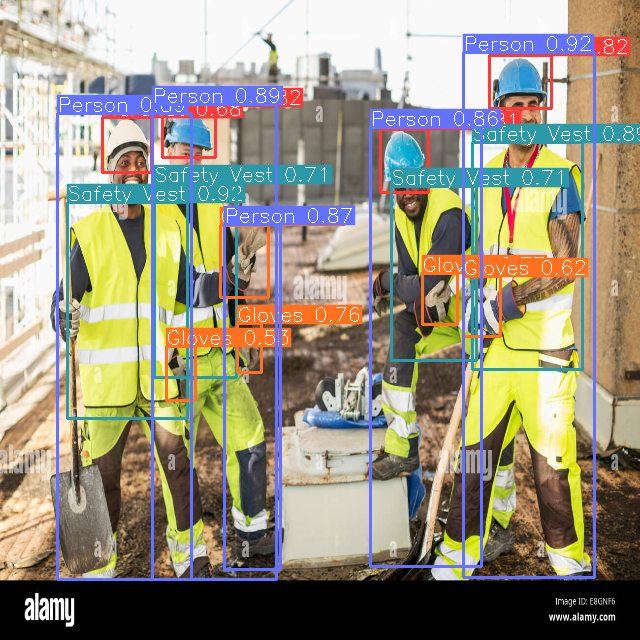

In [63]:
from IPython.display import Image

output_path = "../output"
result.export_visuals(export_dir=output_path)
Image(f"{output_path}/prediction_visual.png")

# Without SAHI

In [64]:
from ultralytics import YOLO

model_path = "../weights/best_yolo_10_70epochs.pt"

model = YOLO(model_path)

In [65]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to the image
start_time = time.time()
# Perform inference
results = model.predict(resized_rgb, conf=0.5)  

finish_time = time.time() - start_time
print(finish_time)
# Check if results are available


0: 640x640 2 Safety Vests, 2 Glovess, 1 Person, 10.2ms
Speed: 2.2ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
0.17862343788146973


5 bounding boxes drawn.


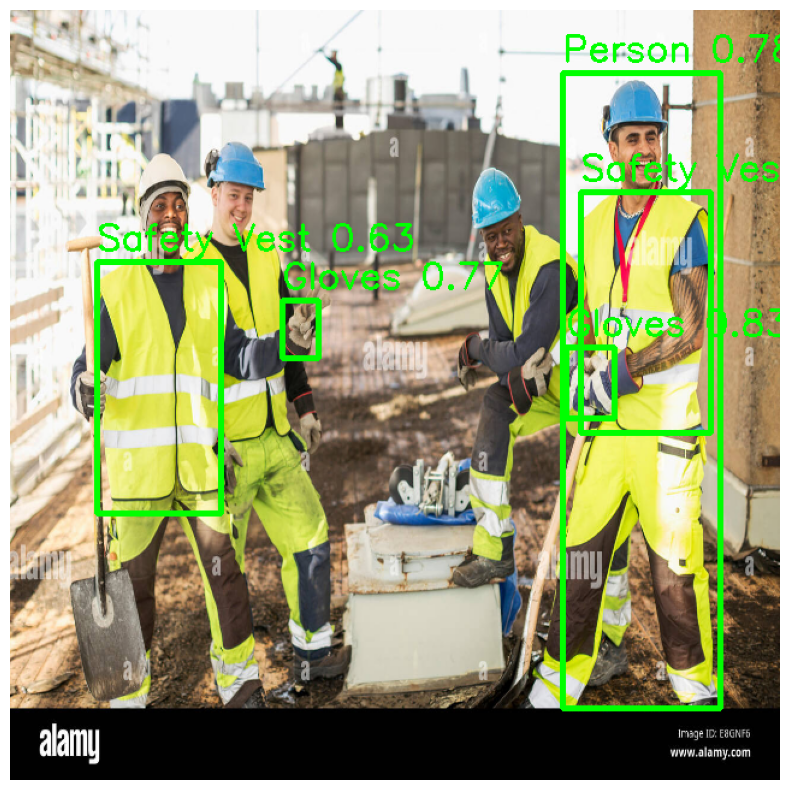

In [66]:
if not results:
    print("No detection results found.")
    exit()

# Ensure the image is loaded
image = resized_rgb.copy()
# Draw bounding boxes on the image
boxes_drawn = 0
for result in results:
    if not result.boxes:
        print("No bounding boxes detected.")
        continue

    for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        x1, y1, x2, y2 = map(int, box)  # Bounding box coordinates
        confidence = float(conf)  # Confidence score
        class_id = int(cls)  # Class ID
        label = f"{model.names[class_id]} {confidence:.2f}"

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 4)
        # Put the label on the image
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        boxes_drawn += 1

# Check if any boxes were drawn
if boxes_drawn == 0:
    print("No bounding boxes were drawn. Try lowering the confidence threshold or using a different image.")
else:
    print(f"{boxes_drawn} bounding boxes drawn.")

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()